<a href="https://colab.research.google.com/github/ToBlick/mrx/blob/main/MRX_tokamak_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### A simple tokamak equilibrium

In this tutorial, we compute an axisymmetric equilibrium magnetic field for a simple tokamak configuration

We begin by installing the MRX package. Make sure to pick the right JAX backend for your colab environment (in the menu at the top: Runtime -> Change runtime type).

We suggest to use a TPU (`!pip install jax["tpu"]`), but you can also chose CPU (`!pip install jax`). If you are a colab subscriber, you can make use of the GPU backend (`!pip install jax["cuda13"]`).

In [ ]:
%%capture
!git clone https://github.com/ToBlick/mrx
%cd mrx
!pip install jax["tpu"]
!pip install .

### Setup

We do the set-up here in a self-contained but verbose manner for clarity. Enabling 64-bit precision is crucial.

In [6]:
%%capture
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from jax.numpy import cos, pi, sin
import diffrax as dfx
from mrx.relaxation import MRXDiagnostics, State, TimeStepper
from mrx.differential_forms import DiscreteFunction
from mrx.derham_sequence import DeRhamSequence
from mrx.mappings import invert_map, approx_inverse_map
from mrx.gvec_interface import interpolate_map_from_GVEC, interpolate_B_from_GVEC
from mrx.plotting import intersect_with_plane, plot_scalar_fct_physical_logical, plot_twin_axis
jax.config.update("jax_enable_x64", True)

NameError: name 'differential_forms' is not defined

The map we use here is that of a simple tokamak with slightly elliptical cross-section, so the only geometric parameters are the aspect ratio $\varepsilon$ and the elongation $\kappa$.

In [7]:
ɛ = 0.33
κ = 1.1

def Phi(x):
    r, θ, ζ = x
    R = 1 + ɛ * r * cos(2 * pi * θ)
    Z = ɛ * κ * r * sin(2 * pi * θ)
    return jnp.array([R * cos(2 * pi * ζ), -R * sin(2 * pi * ζ), Z])

Next, we get our de Rham sequence object...

In [8]:
Seq = DeRhamSequence(
    (12, 12, 1),                         # nb. of splines in (r, θ, ζ)
    (3, 3, 0),                           # degree of splines in (r, θ, ζ)
    5,                                   # nb. of quadrature points per spline
    ("clamped", "periodic", "constant"), # spline type in (r, θ, ζ)
    Phi,                                 # mapping from (r, θ, ζ) to (x, y, z)
    polar=True,                          # domain has a polar singularity
    dirichlet=True                       # impose Dirichlet BCs on r=1 boundary
)

NameError: name 'DeRhamSequence' is not defined

...and assemble the operators we need for the relaxation.

In [ ]:
Seq.evaluate_1d()
Seq.assemble_all()
Seq.build_crossproduct_projections()
Seq.assemble_leray_projection()

Next, we need to decide on an initial magnetic field. We use a Solov'ev state with the parameter $q_*$ determining the ratio of toroidal to poloidal field. The initial field does not satisfy our boundary conditions, so when we project it onto the discrete space, we break the equilibrium. The relaxation will then bring us back to an equilibrium state that does satisfy the boundary conditions.

We provide the field in the cartesian frame $(B_x, B_y, B_z)$ as a function of the logical coordinates $(r, \theta, \zeta)$. In practice, we do so by a de-tour through $(R, \phi, z)$ cylindrical coordinates.

In [ ]:
q_star = 1.54
τ = q_star * κ * (κ**2 + 1) / (κ + 1)

def B_0(p):
        x, y, z = Phi(p)
        R = (x**2 + y**2)**0.5
        phi = jnp.arctan2(y, x)
        BR = z * R
        Bphi = τ / R
        Bz = - (0.5 * κ**2 * (R**2 - 1**2) + z**2)
        Bx = BR * cos(phi) - Bphi * sin(phi)
        By = BR * sin(phi) + Bphi * cos(phi)
        return jnp.array([Bx, By, Bz])

Projection to the discrete space is done as usual via a Galerkin projection. The analytic version of this is given by
$$
    \sum_i \mathtt{B}_i \int_\Omega \Lambda_i^2(x) \cdot \Lambda_j^2(x) \, \mathrm dx = \int_\Omega B_0( \Phi^{-1}(x)) \cdot \Lambda_j^2(x) \, \mathrm dx \quad \forall j
$$
The $i$-th basis function of the two-form space $V_2$, pushed forward to the physical domain, is denoted by $\Lambda_i^2$.
We pull this problem back to the logical domain, apply quadrature and solve for the coefficients $\mathtt{B}_i$.
$$
    \sum_i \mathtt{B}_i \int \hat \Lambda_i^2(\hat x) \cdot \frac{D\Phi(\hat x)^T D\Phi(\hat x)}{\det D\Phi(\hat x)} \hat \Lambda_j^2(\hat x) \, \mathrm d \hat x = \int B_0(\hat x) \cdot D\Phi(\hat x) \hat \Lambda_j^2(\hat x) \, \mathrm d \hat x \quad \forall j
$$
or, in terms of matrices and projectors,
$$
    \mathbb M^2 \, \mathtt{B} = \Pi^2 ( B_0 ).
$$
We apply a Leray projection to make the initial condition exactly discretely divergence-free before starting the relaxation and also normalize it to unit norm.

In [ ]:
B_dof = jnp.linalg.solve(Seq.M2, Seq.P2(B_0))
B_dof = Seq.P_Leray @ B_dof
B_dof /= (B_dof @ Seq.M2 @ B_dof)**0.5

To compute diagnostics throughout the relaxation, we offer a convenience wrapper that computes quantities of interest. The `force_free` flag would restrict to the $\beta=0$ case. We JIT-compile the individual diagnostic functions for performance.

In order to make it more transparent to the user, no function in the MRX source code is compiled by default - the user has to explicitly JIT-compile functions they want to use repeatedly.

In [ ]:
diagnostics = MRXDiagnostics(Seq, force_free=False)
get_pressure = jax.jit(diagnostics.pressure)
get_helicity = jax.jit(diagnostics.helicity)

For the relaxation, we set up a state object to hold all relevant data, parameters and diagnostics. Note that all elements of the state can change throughout the relaxation, it is for example possible to turn on resistivity when the force appears to plateau.

In this example, we do not use the Newton method to move towards the equilibrium and hence set the Hessian matrix to `None`.

In [ ]:
state = State(
        B_dof, # Current magnetic field DOFs B_{n}
        B_dof, # Magnetic field DOFs at next time step B_{n+1}
        1e-3,  # (initial) time-step size dt
        0.0,   # resistivity η
        None,  # Hessian matrix δ²𝓔(B)
        0,     # number of Picard iterations k
        0,     # Picard residual ϵ
        0,     # L2 norm of the force J×B - grad p
        0      # L2 norm of the velocity u
    )

The actual relaxation is done via a `TimeStepper` object that under the hood holds the Picard solver as well as the relaxation update rule. The parameters passed to the `TimeStepper` are constant throughout the relaxation.

In [ ]:
timestepper = TimeStepper(
        Seq,              # de Rham sequence
        gamma=0,          # apply (1 - Δ)^{-γ} to the velocity to smooth it
        newton=False,     # do not use Newton method
        force_free=False, # pressure is non-zero
        picard_tol=1e-12, # Picard solver tolerance
        picard_maxit=20   # max. nb. of Picard iterations before restart with dt/2
    )

As a reminder, what the `TimeStepper` does is at every time step solve the Picard fixed-point problem
$$
\begin{align*}
    B^{n+1/2}_h     &= \frac 1 2 (B^n_h + B^{n+1}_h) \\
    J_h             &= \widetilde{\text{curl}} \, B^{n+1/2}_h, \\
    H_h             &= {\Pi}^1_0 B^{n+1/2}_h, \\
    v_h             &= \mathcal A \, \Pi^2_0 (J_h \times H_h), \\
    E_h             &= {\Pi}^1_0 (v_h \times H_h) - \eta J_h, \\
    B_h^{n+1}       &= B_h^n + \delta t \text{curl} E_h.
\end{align*}
$$
In this tutorial, we have set $\eta = 0$ and $\mathcal A = \Pi^{\text{Leray}}$.

We now get our state-updating method from the timestepper, JIT it for performance, and run it once to compile. This `step` function takes and returns a `State`.

In [ ]:
step = jax.jit(timestepper.picard_solver)
dry_run = step(state)

For this tutorial, we monitor the helicity and force residual throughout the relaxation.

In [ ]:
force_trace = [ dry_run.force_norm ]
helicity_trace = [ get_helicity(dry_run.B_n) ]
print(f"Initial force error: {force_trace[-1]:.2e}")
print(f"Initial helicity: {helicity_trace[-1]:.2e}")

Initial force error: 2.76e-04
Initial helicity: 3.48e-02


We will run the relaxation loop for a fixed number of iterations. It is easy to extend this code to also store the Picard iteration count, time-step size, or other diagnostics.

For reference, using the default resolution ($12 \times 12 \times 1$ cubic B-splines), $10^3$ iterations should take around two minutes on a T4 TPU. If you decide to run this notebook locally, it should take about one minute on an M1 CPU. For higher resolutions, we recommend using a GPU backend.

In [ ]:
num_iters_inner = 100
for i in range(10):
    for _ in range(num_iters_inner):
        state = step(state) # perform one relaxation step
        if (state.picard_residuum > timestepper.picard_tol
                or ~jnp.isfinite(state.picard_residuum)):
            # Picard solver did not converge - reduce dt and retry
            state = timestepper.update_dt(state, state.dt / 2)
            state = timestepper.update_B_guess(state, state.B_n)
            continue
        # otherwise, we converged - proceed
        state = timestepper.update_B_n(state, state.B_guess)

        if state.picard_iterations < 4:
            dt_new = state.dt * 1.01 # took very few Picard iterations - increase dt
        else:
            dt_new = state.dt / 1.01 # took many Picard iterations - decrease dt
        state = timestepper.update_dt(state, dt_new)
    force_trace.append(state.force_norm)
    helicity_trace.append(get_helicity(state.B_n))
    print(f"Iteration {(i+1) * num_iters_inner}, force norm: {state.force_norm:.2e}")

Iteration 100, force norm: 2.31e-04
Iteration 200, force norm: 1.99e-04
Iteration 300, force norm: 1.72e-04
Iteration 400, force norm: 1.48e-04
Iteration 500, force norm: 1.29e-04
Iteration 600, force norm: 1.13e-04
Iteration 700, force norm: 1.00e-04
Iteration 800, force norm: 8.94e-05
Iteration 900, force norm: 8.00e-05
Iteration 1000, force norm: 7.17e-05


At the cost of a bit more complex code we can also replace the inner Python loop with a JAX `lax.scan`. We do not replace both loops here to be able to do logging, storing to disk, etc. more easily in the outer loop. However, the overhead of the Python loop is usually not dominating the actual computation time.

`lax.scan` automatically compiles `body_fn`, so we do not JIT it ourselves, but we note that the entire relaxation process is JIT-ready.

In [ ]:
def body_fn(state, _):
    # ---- one state update ----
    state = step(state)
    failed = (state.picard_residuum > timestepper.picard_tol) | (~jnp.isfinite(state.picard_residuum))
    def on_fail(state):
        state = timestepper.update_dt(state, state.dt / 2)
        state = timestepper.update_B_guess(state, state.B_n)
        return state
    def on_success(state):
        state = timestepper.update_B_n(state, state.B_guess)
        dt_new = jnp.where(state.picard_iterations < 4,
                           state.dt * 1.01,   # few iterations → increase dt
                           state.dt / 1.01)   # many iterations → decrease dt
        return timestepper.update_dt(state, dt_new)
    state = jax.lax.cond(failed, on_fail, on_success, state)
    return state, None

In [ ]:
for i in range(5):
    # ---- run scan ----
    state, _ = jax.lax.scan(body_fn, state, jnp.arange(num_iters_inner))
    force_trace.append(state.force_norm)
    helicity_trace.append(get_helicity(state.B_n))
    print(f"Iteration {(i+11) * num_iters_inner}, force norm: {state.force_norm:.2e}")

Iteration 1100, force norm: 6.44e-05
Iteration 1200, force norm: 5.79e-05
Iteration 1300, force norm: 5.18e-05
Iteration 1400, force norm: 4.57e-05
Iteration 1500, force norm: 3.99e-05
Iteration 1600, force norm: 3.46e-05
Iteration 1700, force norm: 3.13e-05
Iteration 1800, force norm: 2.88e-05
Iteration 1900, force norm: 2.65e-05
Iteration 2000, force norm: 2.47e-05


We plot the force residual and helicity error throughout the relaxation.

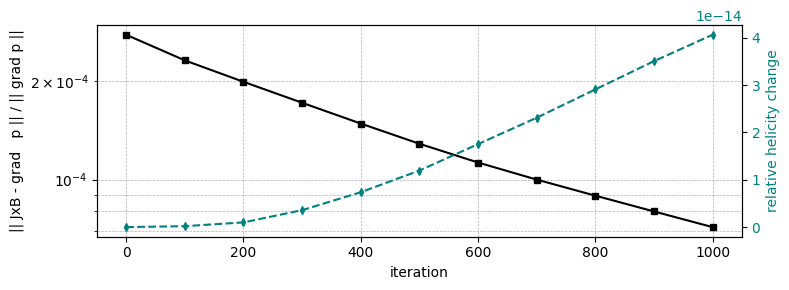

In [ ]:
fig = plot_twin_axis(
    left_y=jnp.array(force_trace),
    right_y=jnp.abs((jnp.array(helicity_trace) - helicity_trace[0]) / helicity_trace[0]),
    left_label='|| JxB - grad   p || / || grad p ||',
    right_label='relative helicity change',
    left_log=True,
    right_log=False,
    num_iters_inner=100,
)
plt.show()

Lastly, some visualizations. We begin by plotting the pressure contours in the logical and physical domain. We also visualize the grid lines and emphasize that our grid is not flux-aligned.

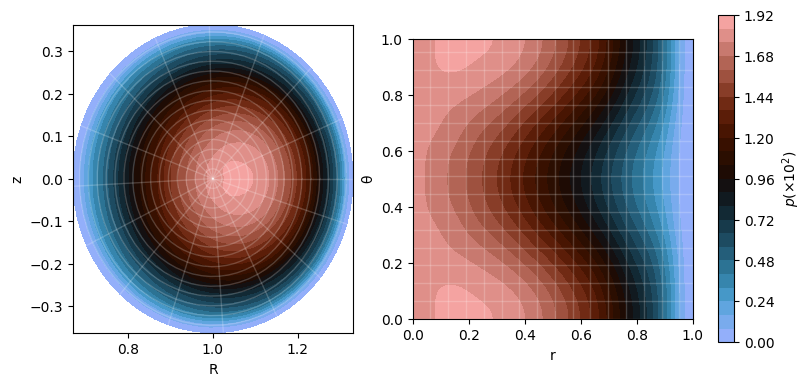

In [ ]:
p_dof = get_pressure(state.B_n)
p_h = jax.jit(DiscreteFunction(p_dof, Seq.Lambda_0, Seq.E0)) # p as a function of logical coordinates

fig = plot_scalar_fct_physical_logical(p_h, Phi, n_vis=64, logical_plane='r_theta', cbar_label="$p (\\times 10^2)$")
plt.show()

We can also plot the pressure in the $\theta$-$\zeta$ plane at fixed $r$, being an axisymmetric equilibrium, this is of course not as interesting.

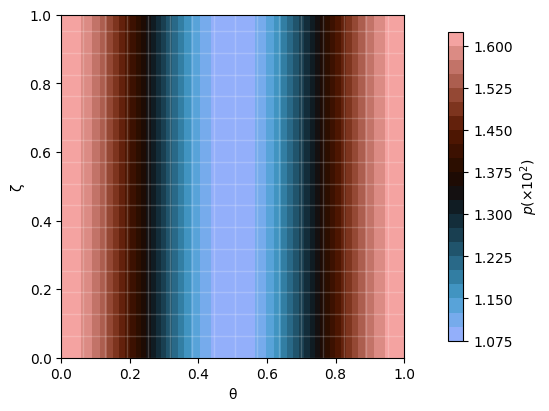

In [ ]:
fig = plot_scalar_fct_physical_logical(p_h, Phi, n_vis=64, logical_plane='theta_zeta', fixed_r=0.5, cbar_label="$p (\\times 10^2)$")
plt.show()

The average plasma beta can be computed by averging the pressure over the volume and dividing by the magnetic energy (in our units $\mu_0 = 1$).

In [ ]:
p_avg = p_dof @ Seq.P0(lambda x: jnp.ones(1)) / (Seq.J_j @ Seq.Q.w)
beta = 2 * p_avg / (state.B_n @ Seq.M2 @ state.B_n)
print(f"plasma β = {beta:.3e}")

plasma β = 1.819e-02


We can estimate the Shafranov shift by finding the location of maximum pressure in the physical domain and measuring its distance from the domain center $(R_0, Z_0) = (1, 0)$.

In [ ]:
x_p_max = _x[jnp.argmax(p_vals)] # cartesian coordinates of argmax p(x)
δR = jnp.linalg.norm(x_p_max - jnp.array([1.0, 0.0, 0.0]))
print(f"Shafranov shift: δR/R₀ ≈ {δR:.2e} = {δR / ɛ**2:.2f} ɛ²")

Shafranov shift: δR/R₀ ≈ 7.48e-02 = 0.69 ɛ²


Lastly, we compute a Poincaré plot of the field lines to visualize the magnetic surfaces. We trace field lines by integrating the magnetic field in the logical domain where it hold (see the MRX paper for details):
$$
    \frac{\mathrm d }{\mathrm d t} x_t = \frac{B(x_t)}{| B(x_t)|} \quad \Leftrightarrow \quad \frac{\mathrm d }{\mathrm d t} \hat x_t = \frac{\hat B(\hat x_t)}{| D\Phi(\hat x_t) \hat B(\hat x_t)|}.
$$
The actual integration is done with the `diffrax` package.

In [ ]:
B_h = DiscreteFunction(state.B_n, Seq.Lambda_2, Seq.E2)

def vector_field(t, x, args):
    x %= 1.0
    Bx = B_h(jnp.array(x))
    DFx = jax.jacfwd(Phi)(jnp.array(x))
    return Bx / jnp.linalg.norm(DFx @ Bx)

def integrate_fieldline(f, x0, N, t1):
    t0 = 0.0
    sol = dfx.diffeqsolve(
        terms = dfx.ODETerm(f),
        solver = dfx.Dopri5(),
        t0 = t0,
        t1 = t1,
        dt0 = 0.05,
        y0 = x0,
        saveat = dfx.SaveAt(ts=jnp.linspace(t0, t1, N)),
        stepsize_controller = dfx.PIDController(rtol=1e-8, atol=1e-8),
        max_steps = 100_000)
    return sol.ys

We can vectorize the field line tracing over multiple starting points. Starting points on the line $\{ \hat x = (r, 0, 0) : \epsilon < r < 1 - \epsilon \}$. The computed trajectories are in logical coordinates and we map them to physical coordinates for visualization.

Integrating 32 field lines until $T = 2 \times 10^3$ takes around 1 minute on a T4 TPU (M1 CPU: 2 minutes) and produces roughly $2 \times 10^3 / (2 \pi) \approx 3 \times 10^2$ toroidal turns per field line. We store $N = 10 T$ samples per field line for visualization.

In [ ]:
T = 2000
N = 10 * T
n_traj = 32
r_vals = jnp.linspace(0.01, 0.99, n_traj // 2)
x0s_theta0 = jnp.stack([r_vals, jnp.zeros_like(r_vals), jnp.zeros_like(r_vals)], axis=1)
x0s_theta05 = jnp.stack([r_vals, 0.5 * jnp.ones_like(r_vals), jnp.zeros_like(r_vals)], axis=1)
x0s = jnp.concatenate([x0s_theta0, x0s_theta05], axis=0)
B_h = jax.jit(DiscreteFunction(state.B_n, Seq.Lambda_2, Seq.E2))
logical_trajectories = jax.vmap(
    lambda x0: integrate_fieldline(vector_field, x0, N, T)
    )(x0s) % 1.0
physical_trajectories = jax.vmap(Phi)(logical_trajectories.reshape(-1, 3)).reshape(n_traj, N, 3)

To produce a Poincaré plot, we use a root-finding algorithm to find the intersection of the field lines with a given plane.

In [ ]:
intersections, idxs = jax.vmap(lambda t: intersect_with_plane(t, jnp.array([0.0, 1.0, 0.0]), 0.0, 3))(physical_trajectories)

To obtain said intersection points in the logical domain, we need to invert the map $\Phi$. We do so via a Newton method, using the inverse circular cross-section tokamak map with aspect ratio $\varepsilon$ as initial guess.

In [ ]:
logical_intersections = jax.vmap(
        lambda pt: invert_map(Phi, pt, lambda x: approx_inverse_map(x, ɛ))
    )(intersections.reshape(-1, 3)).reshape(intersections.shape) % 1

Lastly, we plot the Poincaré section in the physical domain and color the points by the pressure. Since JAX operates under the assumption of static shapes, the intersection points are padded to the shape of the trajectory array with `NaN`s. We mask these before plotting.

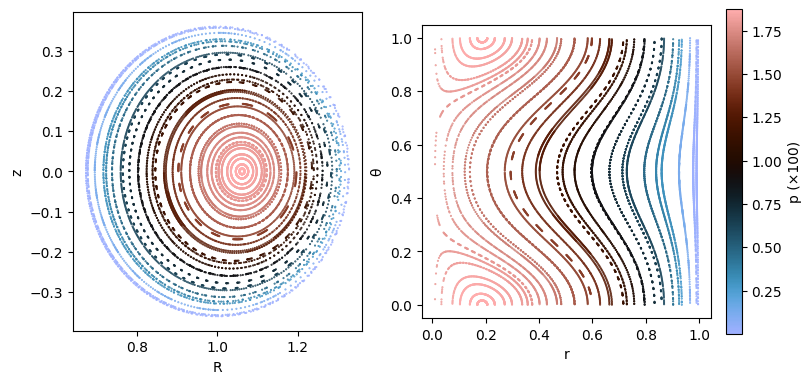

In [ ]:
mask = (~jnp.isnan(intersections[..., 0])) & (intersections[..., 0] > 0)
pts_phys = intersections[mask]
pts_log  = logical_intersections[mask]
p_vals = jax.vmap(p_h)(pts_log)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), constrained_layout=True)
# physical
s1 = ax1.scatter(
    pts_phys[:, 0], pts_phys[:, 2],
    c=p_vals*100,
    cmap="berlin",
    s=0.25,
)
ax1.set(xlabel="R", ylabel="z", aspect="equal")
# logical
r, θ = _rgrid.squeeze(), _θgrid.squeeze()
s2 = ax2.scatter(
    pts_log[:, 0], pts_log[:, 1],
    c=p_vals*100,
    cmap="berlin",
    s=0.25,
)
ax2.set(xlabel="r", ylabel="θ", aspect="equal")
fig.colorbar(s2, ax=ax2, label="p (×100)", shrink=0.9)
plt.show()

### GVEC MAP

Finally, we provide an example of using a GVEC equilibrium map. We use the geometric specified in one of the GVEC tutorials, which is stored in a hdf5 file.

In [ ]:
import xarray as xr

gvec_eq = xr.open_dataset("data/gvec_tokamak.h5", engine="h5netcdf")

The data file contains two one-dimensional arrays specifying the grid in $\rho$ ($r$ in our notation), $\theta$, and $\zeta$ as well as two three-dimensional arrays specifying the $X_1$ and $X_2$ coordinates of the grid points.

To make this mapping evaluable at arbitrary points, we solve an interpolation problem onto a spline basis to approximate $X_1$ and $X_2$. We get another de Rham sequence object for this purpose, this one is importantly not defined with a polar singularity, but rather on a rectangular domain.

The interpolation problem is defined as
$$
 X_{h,\alpha}(\hat x_j) = \sum_i c_i^\alpha \Lambda_i^0(\hat x_j) = X_\alpha(\hat x_j) \quad \forall
 j = 1, \ldots, m_r m_\theta, \; \alpha \in \{1, 2\}.
$$
and the mapping is
$$
 \Phi_{\text{GVEC}}(\hat x) = \begin{pmatrix}
  X_{h,1}(\hat x) \cos(2 \pi \zeta) \\
  -X_{h,1}(\hat x) \sin(2 \pi \zeta) \\
  X_{h,2}(\hat x)
 \end{pmatrix}.
$$

In [ ]:
mapSeq = DeRhamSequence((12, 12, 1), (3, 3, 0), 5, ("clamped", "periodic", "constant"), lambda x: x, polar=False, dirichlet=False)
Phi_GVEC = jax.jit(interpolate_map_from_GVEC(gvec_eq=gvec_eq, nfp=1, mapSeq=mapSeq))

We plot the grid defined by this mapping to verify that it looks as expected.

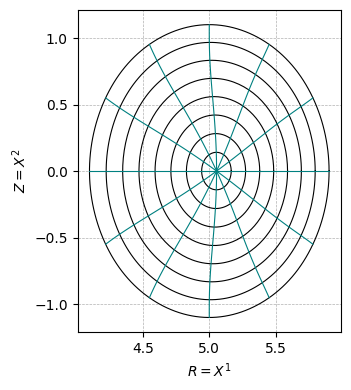

In [ ]:
m_r, m_th = 80, 180
r_vals = jnp.linspace(0.0, 1.0, m_r)
theta = jnp.linspace(0.0, 2*pi, m_th)
fig, ax = plt.subplots(figsize=(5,4))
# constant-r lines
for r in jnp.linspace(0,1,9):
    pts = jnp.stack([jnp.full_like(theta, r), (theta/(2*pi)) % 1.0, jnp.zeros_like(theta)], axis=1)
    ax.plot(jax.vmap(X1_h)(pts),jax.vmap(X2_h)(pts),'k',lw=0.8)
# constant-θ lines
for th in jnp.linspace(0,1,12,endpoint=False):
    pts = jnp.stack([r_vals, jnp.full_like(r_vals, th), jnp.zeros_like(r_vals)], axis=1)
    ax.plot(jax.vmap(X1_h)(pts), jax.vmap(X2_h)(pts), color='teal',lw=0.8)
ax.set(xlabel='$R=X^1$', ylabel='$Z=X^2$', aspect='equal'); ax.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

Al everything seems in order, we get everything in place for the relaxation. We will simply overwrite the previous de Rham sequence with the GVEC one.

In [ ]:
Seq = DeRhamSequence((12, 12, 1), (3, 3, 0), 5, ("clamped", "periodic", "constant"), Phi_GVEC, polar=True, dirichlet=True)
Seq.evaluate_1d()
Seq.assemble_all()
Seq.build_crossproduct_projections()
Seq.assemble_leray_projection()
diagnostics = MRXDiagnostics(Seq, force_free=False)
get_pressure = jax.jit(diagnostics.pressure)
get_helicity = jax.jit(diagnostics.helicity)
timestepper = TimeStepper(Seq, gamma=0, newton=False, force_free=False, picard_tol=1e-12, picard_maxit=20)

Naturally, we use the magnetic field provided by GVEC as initial condition for the relaxation. This again provided boils down to an interpolation problem, where the interpolation points are determined by the GVEC output file. We formulate this problem in physical space and push the basis functions forward via the GVEC map:
$$
    \sum_i \mathtt{B}_i \, (\det D\Phi(x_j) )^{-1} D\Phi(x_j) \Lambda_i^2(x_j) = B_{\text{GVEC}}(x_j) \quad \forall j
$$

In [ ]:
B_dof, residuals = interpolate_B_from_GVEC(gvec_eq, Seq, Phi_GVEC, nfp=1)
print(f"Interpolation residual: {residuals[0]:.2e}")

Interpolation residual: 2.46e-04


Next, we check by how much we perturbed the GVEC equilibrium due to the low resolution of the approximation space and the interpolation error.

In [ ]:
print(f"div B after interpolation: {((Seq.strong_div @ B_dof) @ Seq.M3 @ (Seq.strong_div @ B_dof))**0.5:.2e}")
B_dof = Seq.P_Leray @ B_dof
B_dof /= (B_dof @ Seq.M2 @ B_dof)**0.5
print(f"div B after Leray projection: {((Seq.strong_div @ B_dof) @ Seq.M3 @ (Seq.strong_div @ B_dof))**0.5:.2e}")
state = State(B_dof, B_dof, 1e-3, 0.0, None, 0, 0, 0, 0)
step = jax.jit(timestepper.picard_solver)
dry_run = step(state)
force_trace = [ dry_run.force_norm ]
helicity_trace = [ get_helicity(dry_run.B_n) ]
print(f"Initial force error: {force_trace[-1]:.2e}")
print(f"Initial helicity: {helicity_trace[-1]:.2e}")

div B after interpolation: 3.80e-05
div B after Leray projection: 6.81e-17
Initial force error: 1.13e-05
Initial helicity: 8.44e-02
Initial force error: 1.13e-05
Initial helicity: 8.44e-02


Setting up the body of the relaxation iteration is identical to before:

In [ ]:
def body_fn(state, _):
    # ---- one state update ----
    state = step(state)
    failed = (state.picard_residuum > timestepper.picard_tol) | (~jnp.isfinite(state.picard_residuum))
    def on_fail(state):
        state = timestepper.update_dt(state, state.dt / 2)
        state = timestepper.update_B_guess(state, state.B_n)
        return state
    def on_success(state):
        state = timestepper.update_B_n(state, state.B_guess)
        dt_new = jnp.where(state.picard_iterations < 4,
                           state.dt * 1.01,   # few iterations → increase dt
                           state.dt / 1.01)   # many iterations → decrease dt
        return timestepper.update_dt(state, dt_new)
    state = jax.lax.cond(failed, on_fail, on_success, state)
    return state, None

...and so is running it:

In [ ]:
for i in range(10):
    # ---- run scan ----
    state, _ = jax.lax.scan(body_fn, state, jnp.arange(num_iters_inner))
    force_trace.append(state.force_norm)
    helicity_trace.append(get_helicity(state.B_n))
    print(f"Iteration {(i) * num_iters_inner}, force norm: {state.force_norm:.2e}")

Iteration 1100, force norm: 1.12e-05
Iteration 1200, force norm: 1.10e-05
Iteration 1200, force norm: 1.10e-05
Iteration 1300, force norm: 1.05e-05
Iteration 1300, force norm: 1.05e-05
Iteration 1400, force norm: 9.41e-06
Iteration 1400, force norm: 9.41e-06
Iteration 1500, force norm: 8.08e-06
Iteration 1500, force norm: 8.08e-06
Iteration 1600, force norm: 6.98e-06
Iteration 1600, force norm: 6.98e-06
Iteration 1700, force norm: 6.09e-06
Iteration 1700, force norm: 6.09e-06
Iteration 1800, force norm: 5.40e-06
Iteration 1800, force norm: 5.40e-06
Iteration 1900, force norm: 4.74e-06
Iteration 1900, force norm: 4.74e-06
Iteration 2000, force norm: 4.02e-06
Iteration 2000, force norm: 4.02e-06


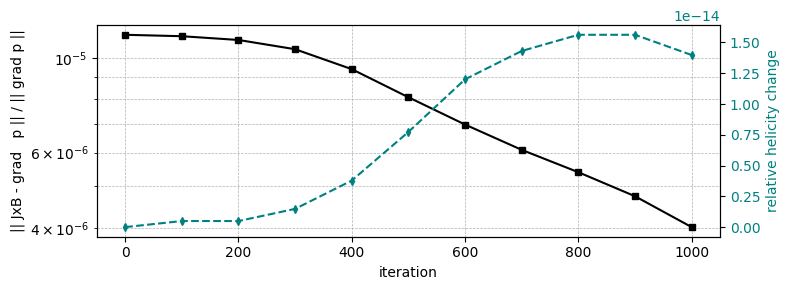

In [ ]:
fig = plot_twin_axis(
    left_y=jnp.array(force_trace),
    right_y=jnp.abs((jnp.array(helicity_trace) - helicity_trace[0]) / helicity_trace[0]),
    left_label='|| JxB - grad   p || / || grad p ||',
    right_label='relative helicity change',
    left_log=True,
    right_log=False,
    num_iters_inner=100,
)
plt.show()

In [ ]:
p_dof = get_pressure(B_dof)
p_h = jax.jit(DiscreteFunction(p_dof, Seq.Lambda_0, Seq.E0)) # p as a function of logical coordinates

fig = plot_scalar_fct_physical_logical(p_h, Phi_GVEC, n_vis=64, logical_plane='r_theta', cbar_label="$p (\\times 10^2)$")

NameError: name 'get_pressure' is not defined

In [ ]:
B_h = DiscreteFunction(state.B_n, Seq.Lambda_2, Seq.E2)

def vector_field(t, x, args):
    x %= 1.0
    Bx = B_h(jnp.array(x))
    DFx = jax.jacfwd(Phi_GVEC)(jnp.array(x))
    return Bx / jnp.linalg.norm(DFx @ Bx)

def integrate_fieldline(f, x0, N, t1):
    t0 = 0.0
    sol = dfx.diffeqsolve(
        terms = dfx.ODETerm(f),
        solver = dfx.Dopri5(),
        t0 = t0,
        t1 = t1,
        dt0 = 0.05,
        y0 = x0,
        saveat = dfx.SaveAt(ts=jnp.linspace(t0, t1, N)),
        stepsize_controller = dfx.PIDController(rtol=1e-8, atol=1e-8),
        max_steps = 100_000)
    return sol.ys
T = 2000
N = 5 * T
n_traj = 16
r_vals = jnp.linspace(0.01, 0.99, n_traj // 2)
x0s_theta0 = jnp.stack([r_vals, jnp.zeros_like(r_vals), jnp.zeros_like(r_vals)], axis=1)
x0s_theta05 = jnp.stack([r_vals, 0.5 * jnp.ones_like(r_vals), jnp.zeros_like(r_vals)], axis=1)
x0s = jnp.concatenate([x0s_theta0, x0s_theta05], axis=0)
B_h = jax.jit(DiscreteFunction(state.B_n, Seq.Lambda_2, Seq.E2))
logical_trajectories = jax.vmap(
    lambda x0: integrate_fieldline(vector_field, x0, N, T)
    )(x0s) % 1.0
physical_trajectories = jax.vmap(Phi_GVEC)(logical_trajectories.reshape(-1, 3)).reshape(n_traj, N, 3)

: 

In [ ]:
def approx_inverse_map(y: jnp.ndarray, eps: float, R0: float = 1.0) -> jnp.ndarray:
    """
    Approximate inverse mapping function.

    Parameters
    ----------
    y : jnp.ndarray
        Input coordinates.
    eps : float
        Eccentricity of the ellipse.

    Returns
    -------
    x : jnp.ndarray
        Output coordinates.
    """
    X, Y, Z = y
    R = jnp.sqrt(X**2 + Y**2)
    ζ = (jnp.arctan2(-Y, X) / (2 * pi)) % 1.0
    r = jnp.sqrt(((R - R0) / eps)**2 + (Z / (eps))**2)
    θ = (jnp.arctan2(Z / (eps * r), (R - R0) / (eps * r)) / (2 * pi)) % 1.0
    return jnp.array([r, θ, ζ])

In [ ]:
intersections, idxs = jax.vmap(lambda t: intersect_with_plane(t, jnp.array([0.0, 1.0, 0.0]), 0.0, 3))(physical_trajectories)
logical_intersections = jax.vmap(
        lambda pt: invert_map(Phi_GVEC, pt, lambda x: approx_inverse_map(x, eps=1, R0=5))
    )(intersections.reshape(-1, 3)).reshape(intersections.shape) % 1

In [ ]:
mask = (~jnp.isnan(intersections[..., 0])) & (intersections[..., 0] > 0)
pts_phys = intersections[mask]
pts_log  = logical_intersections[mask]
p_vals = jax.vmap(p_h)(pts_log)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), constrained_layout=True)
# physical
s1 = ax1.scatter(
    pts_phys[:, 0], pts_phys[:, 2],
    c=p_vals*100,
    cmap="berlin",
    s=0.25,
)
ax1.set(xlabel="R", ylabel="z", aspect="equal")
# logical
r, θ = _rgrid.squeeze(), _θgrid.squeeze()
s2 = ax2.scatter(
    pts_log[:, 0], pts_log[:, 1],
    c=p_vals*100,
    cmap="berlin",
    s=0.25,
)
ax2.set(xlabel="r", ylabel="θ", aspect="equal")
fig.colorbar(s2, ax=ax2, label="p (×100)", shrink=0.9)
plt.show()